In [40]:
"""
Notebook to pose unposed cameras. Run after running 2-extrinsics.py

Pseudocode:
- Load cameras
    - If camera is posed add to posed_cameras
    - If camera is unposed add to unposed_cameras
- For each unposed camera in unposed_cameras do:
    - Find the closest posed camera
    - Select keypoints in overlapping views
    - Solve PnP to get pose of unposed camera
    - Add the posed camera to posed_cameras
    - Remove the unposed camera from unposed_cameras
    - Update extrinsics
"""





'\nNotebook to pose unposed cameras. Run after running 2-extrinsics.py\n\nPseudocode:\n- Load cameras\n    - If camera is posed add to posed_cameras\n    - If camera is unposed add to unposed_cameras\n- For each unposed camera in unposed_cameras do:\n    - Find the closest posed camera\n    - Select keypoints in overlapping views\n    - Solve PnP to get pose of unposed camera\n    - Add the posed camera to posed_cameras\n    - Remove the unposed camera from unposed_cameras\n    - Update extrinsics\n'

In [45]:
# Load Cameras

import os
import sys
import numpy as np
import json

sys.path.append('..')
from configs.arguments import get_config_dict
from utils.multiview_utils import Camera, Calibration, MultiviewVids
from utils.io_utils import write_json, load_json
from utils.metadata_utils import get_cam_names
from utils.coordinate_utils import update_reconstruction, point_in_polygon, project_to_ground_plane_cv2
from utils.plot_utils import rotation_matrix, perp

from scipy.spatial.transform import Rotation as R
from skspatial.objects import Point, Vector, Plane, Points, Line
import pyransac3d as pyrsc

import copy
import cv2
import ipywidgets as widgets
import ipympl
import matplotlib.pyplot as plt
%matplotlib widget

In [46]:


arv_copy = sys.argv
sys.argv = ['pop']
sys.argv.append('-cfg')
config_path = os.path.abspath('../../project_config.yaml')
sys.argv.append(config_path)
sys.argv.append('-dr')
root_path = os.path.abspath('../../data/')
sys.argv.append(root_path)
sys.argv.append('-l')
sys.argv.append('info')

# load arguments from the arg parser
config = get_config_dict()
data_root = config["main"]["data_root"]
calib_dir = os.path.join(data_root, '0-calibration', 'calibs')
video_dir = os.path.join(data_root, 'raw_data', 'footage')
reconstruction_dir = os.path.join(data_root, '0-calibration', 'opensfm', 'undistorted', 'reconstruction.json')
omni_tag = '360'


reconstruction_dir = os.path.join(data_root, '0-calibration', 'opensfm', 'reconstruction.json')
if not os.path.exists(reconstruction_dir):
    print( "Reconstruction not found. Please run 0-calibration/2-extrinsics.py first.")
    

Reconstruction not found. Please run 0-calibration/2-extrinsics.py first.


In [44]:
# load interval json
interval_json = os.path.join(data_root, '0-calibration', 'calibs', 'interval.json')

# select_interval 
interval_idx = 0
interval_json = load_json(interval_json)
interval = interval_json[interval_json.keys()[interval_idx]]

# load cameras
cam_names = interval['cameras']

# load interval reconstruction
reconstruction = load_json(reconstruction_dir / interval_json.keys()[interval_idx])

# load calibrated cameras
calibrated_cameras = {}
for cam_name in cam_names:
    calib_path = os.path.join(calib_dir, cam_name + '.json')
    calib = load_json(calib_path)
    calibrated_cameras[cam_name] = calib


# load unposed cameras
unposed_cameras = {}
for cam_name in cam_names:
    if cam_name not in reconstruction['cameras']:
        unposed_cameras[cam_name] = calibrated_cameras[cam_name]



ValueError: Unable to read JSON /Users/grosche/Documents/GitHub/CVLAB/MARMOT/data/0-calibration/calibs/interval.json

In [12]:
import pickle
import numpy as np
import gzip

with gzip.open('../../data/0-calibration/opensfm/matches/cam1_100.jpg_matches.pkl.gz', 'rb') as f:
    matches = pickle.load(f)

features = np.load('../../data/0-calibration/opensfm/features/cam1_100.jpg.features.npz')


In [16]:
features.files

['points',
 'descriptors',
 'colors',
 'segmentations',
 'instances',
 'segmentation_labels',
 'OPENSFM_FEATURES_VERSION']

In [17]:
len(features['points'])

4951

In [99]:
# load tracks csv
import pandas as pd
tracks = pd.read_csv('../../data/0-calibration/opensfm/tracks.csv', delimiter='\t', skiprows=1, names=['image', 'track_id', 'feature_id', 'x', 'y', 'scale', 'r', 'g', 'b', 'segmentation', 'instance'])





In [92]:
landmarks = {}
import cv2

for i in range(len(tracks)):
    if tracks.iloc[i].image not in landmarks:
        landmarks[tracks.iloc[i].image]['landmarks'] = []
        landmarks[tracks.iloc[i].image]['ids'] = []

    img = cv2.imread(f'../../data/0-calibration/opensfm/images/{tracks.iloc[i].image}')
    scale_factor = max(img.shape)
    # convert from normalized to pixel coordinates
    rescaled_x = (tracks.iloc[i].x + 0.5) * img.shape[1]
    rescaled_y = (tracks.iloc[i].y + 0.5) * img.shape[0]

    landmarks[tracks.iloc[i].image]['landmarks'].append([rescaled_x, rescaled_y])
    landmarks[tracks.iloc[i].image]['ids'].append(tracks.iloc[i].track_id)


KeyboardInterrupt: 

In [100]:
tracks.head()

,image,track_id,feature_id,x,y,scale,r,g,b,segmentation,instance
0,cam3_100.jpg,32580,723,0.384756,-0.092820,0.001479,163,125,63,-1,-1
1,cam3_100.jpg,32578,292,-0.016316,-0.189206,0.001423,19,19,7,-1,-1
2,cam3_100.jpg,32577,280,-0.092499,0.110109,0.001422,158,130,83,-1,-1
3,cam3_100.jpg,32574,414,0.346452,-0.014784,0.001437,94,61,26,-1,-1
4,cam3_100.jpg,32571,4475,-0.249039,-0.229327,0.003994,90,66,28,-1,-1


In [115]:
# create landmarks.json file
# the output is a dictionary with keys as image names and values as a dictionary with keys 'landmarks' and 'ids'. The ids are the track ids of the landmarks in the image. The landmarks are the pixel coordinates of the landmarks in the image.

import cv2
import pandas as pd
import numpy as np

tracks = pd.read_csv('../../data/0-calibration/opensfm/tracks.csv', delimiter='\t', skiprows=1, names=['image', 'track_id', 'feature_id', 'x', 'y', 'scale', 'r', 'g', 'b', 'segmentation', 'instance'])

def process_group(group):
    img = cv2.imread(f'../../data/0-calibration/opensfm/images/{group.name}')
    scale_factor = max(img.shape)
    group['x'] = ((group['x'] + 0.5) * img.shape[1]).astype(int)
    group['y'] = ((group['y'] + 0.5) * img.shape[0]).astype(int)
    return {'landmarks': group[['x', 'y']].values.tolist(), 'ids': group['track_id'].values.tolist()}

landmarks = tracks.groupby('image').apply(process_group).to_dict()

# save landmarks to json
import json
with open('../../data/0-calibration/opensfm/landmarks.json', 'w') as f:
    json.dump(landmarks, f, indent=4)


# create landmarks_global.json file
# the output is a dictionary with keys as track ids and values x,y,z in world coordinates.
    



    

In [114]:
# load reconstruction
import json
with open('../../data/0-calibration/opensfm/reconstruction.json') as f:
    reconstruction = json.load(f)[0]

landmarks_global = {}
landmarks_global['ids'] = []
landmarks_global['points'] = []
for key, value in reconstruction['points'].items():
    landmarks_global['ids'].append(key)
    landmarks_global['points'].append(value['coordinates'])

# save landmarks_global to json
with open('../../data/0-calibration/opensfm/landmarks_global.json', 'w') as f:
    json.dump(landmarks_global, f, indent=4)

In [112]:
landmarks_global

{'ids': ['4113',
  '4730',
  '2750',
  '1528',
  '1445',
  '3697',
  '904',
  '3695',
  '3701',
  '1811',
  '1390',
  '2262',
  '3700',
  '4070',
  '3704',
  '528',
  '3200',
  '2439',
  '3452',
  '2279',
  '864',
  '1589',
  '1890',
  '3861',
  '1442',
  '1833',
  '28',
  '2349',
  '2838',
  '4790',
  '2889',
  '1841',
  '1651',
  '3596',
  '4457',
  '2818',
  '2996',
  '1002',
  '457',
  '1315',
  '55',
  '967',
  '8808',
  '8971',
  '22347',
  '8815',
  '22348',
  '8590',
  '8608',
  '8848',
  '9004',
  '8899',
  '6448',
  '7051',
  '5545',
  '7322',
  '7484',
  '7372',
  '6375',
  '6072',
  '6105',
  '9852',
  '5763',
  '6707',
  '10008',
  '9846',
  '8250',
  '7379',
  '6122',
  '7691',
  '8354',
  '7659',
  '7403',
  '7876',
  '8399',
  '9166',
  '5939',
  '5796',
  '5533',
  '13193',
  '13349',
  '13582',
  '12926',
  '12654',
  '12954',
  '13044',
  '13319',
  '13556',
  '13018',
  '13574',
  '13570',
  '12787',
  '13249',
  '13093',
  '12698',
  '13156',
  '13134',
  '12980',


In [69]:
# convert to list of ints
recon_keys = [int(keypoint) for keypoint in reconstruction[0]['points'].keys()]

len(recon_keys)

17097

In [23]:
# output number of unique rows
unique_rows = np.unique(features['descriptors'], axis=1)

In [24]:
len(unique_rows)

4951

In [25]:
features['descriptors']

array([[  1,  22, 164, ...,  15,  67,  17],
       [ 24,  94, 110, ...,  30,  39,   9],
       [ 18,  31,  39, ...,  98, 108,  17],
       ...,
       [ 28,  36,  44, ...,  88, 153, 174],
       [  0,   0,   2, ...,  69,  44,  23],
       [ 52,   0,   1, ...,  21,  12,  20]], dtype=uint8)

No matches for image pair cam1_432.jpg - cam4_12030.jpg
No matches for image pair cam1_432.jpg - cam360_765.jpg
No matches for image pair cam1_432.jpg - cam360_587.jpg
No matches for image pair cam1_432.jpg - cam3_12160.jpg
No matches for image pair cam1_432.jpg - cam3_1351.jpg


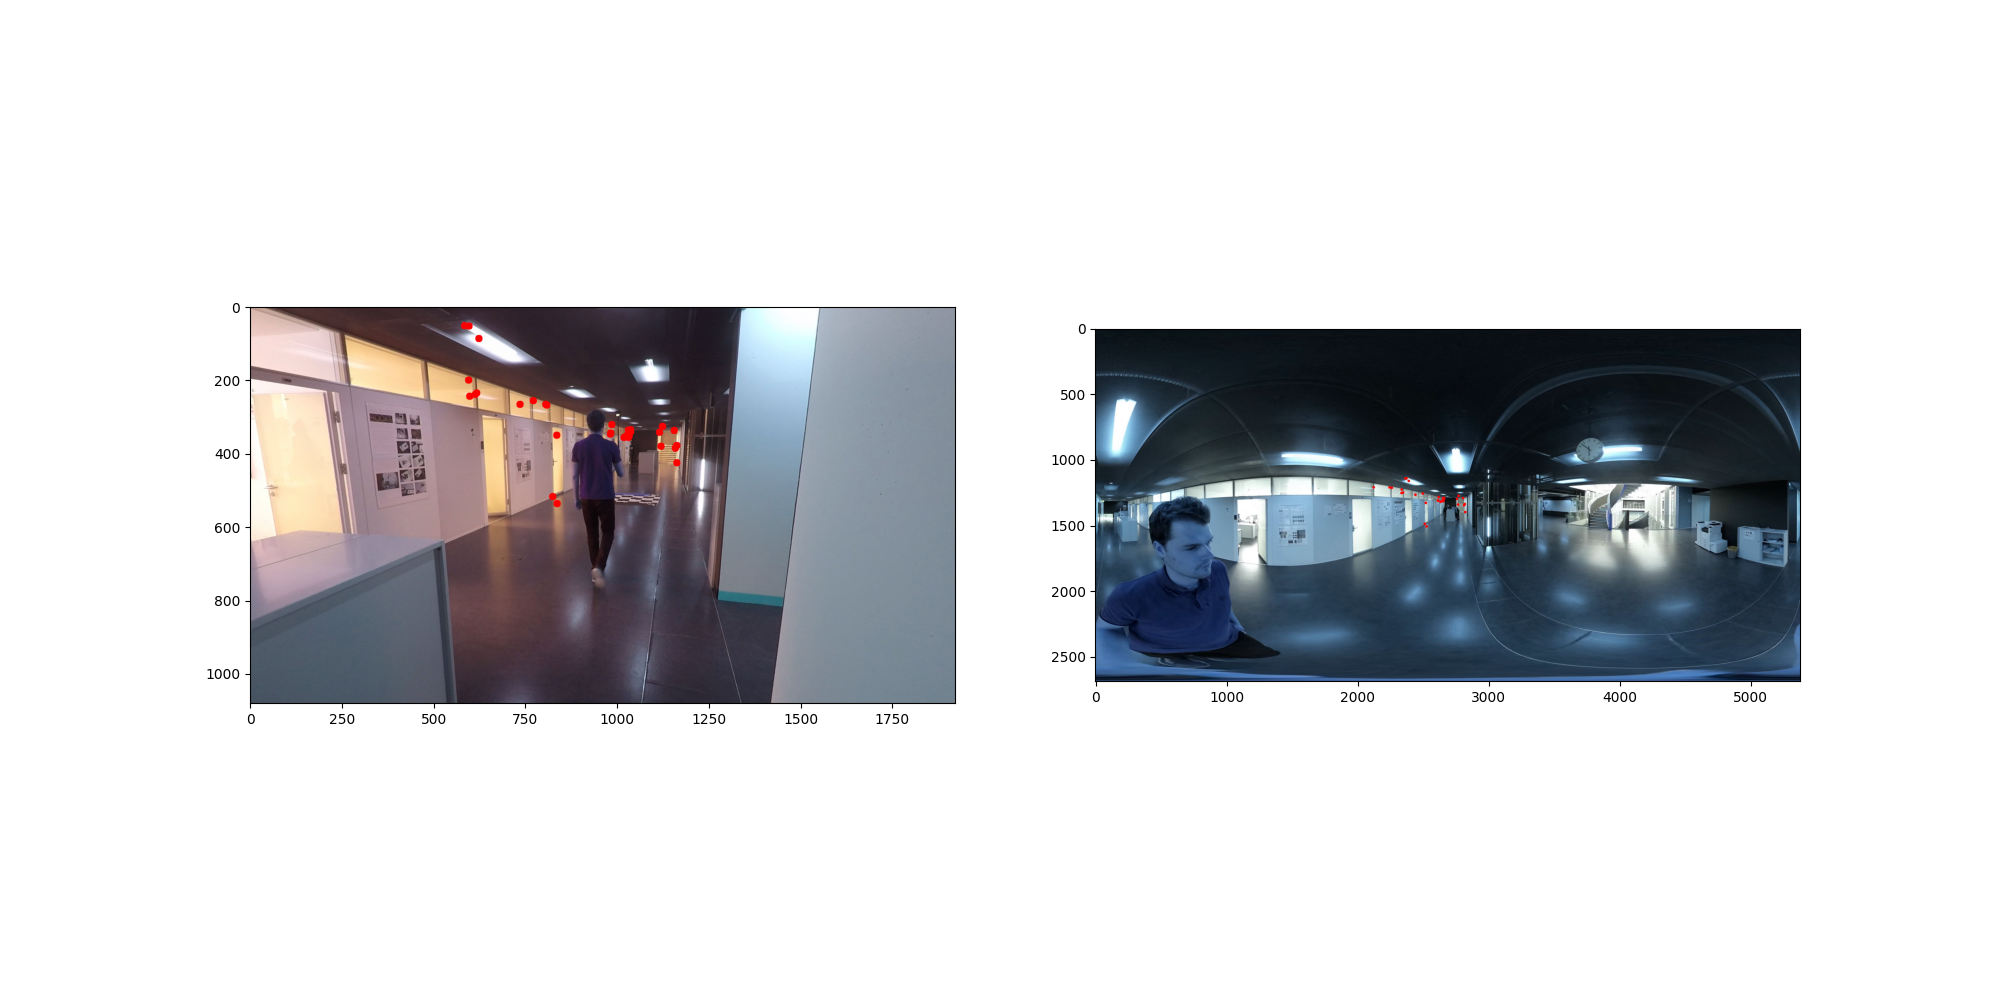

In [47]:
import gzip
import os
import matplotlib.pyplot as plt
import cv2
import pickle
import numpy as np
%matplotlib widget

def opensfm_matches_visual(opensfm_folder, base_image_name):
    """
    Visualize matches between two cameras
    """

    # load matches (unzip gz and de-pickle)
    matches_path = os.path.join(opensfm_folder, 'matches', base_image_name + '_matches.pkl.gz')

    with gzip.open(matches_path, 'rb') as f:
        matches = pickle.load(f)

    # load features
    features_path = os.path.join(opensfm_folder, 'features', base_image_name + '.features.npz')
    features = np.load(features_path)

    number_of_matched_cams = len(matches.keys())
    fig, axs = plt.subplots(1, 1 + 1, figsize=(20, 10))
    i = 0
    for match in matches:
        if not len(matches[match]) > 0:
            print('No matches for image pair {} - {}'.format(base_image_name, match))
            continue
        i += 1
        if i > 1:
            break
        # get feature indices
        idx1 = matches[match][:, 0]
        idx2 = matches[match][:,1]

        # load feature locations for matched cam
        features_path_2 = os.path.join(opensfm_folder, 'features', match + '.features.npz')
        features_2 = np.load(features_path_2)

        # get feature locations
        pt1 = features['points'][idx1]
        pt2 = features_2['points'][idx2]

        def denormalized_image_coordinates(
            norm_coords: np.ndarray, width: int, height: int
        ) -> np.ndarray:
            size = max(width, height)
            p = np.empty((len(norm_coords), 2))
            p[:, 0] = norm_coords[:, 0] * size - 0.5 + width / 2.0
            p[:, 1] = norm_coords[:, 1] * size - 0.5 + height / 2.0
            return p
        
        
        
        # load images
        image_path = os.path.join(opensfm_folder, 'images', base_image_name)
        image = plt.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_path_2 = os.path.join(opensfm_folder, 'images', match)
        image_2 = plt.imread(image_path_2)
        image_2 = cv2.cvtColor(image_2, cv2.COLOR_BGR2RGB)

        # denormalize points
        pt1 = denormalized_image_coordinates(pt1, image.shape[1], image.shape[0])
        pt2 = denormalized_image_coordinates(pt2, image_2.shape[1], image_2.shape[0])


        for point in pt1:
            point = tuple(map(int, point))
            cv2.circle(image, point, 10, (255, 0, 0), -1)

        for point in pt2:
            point = tuple(map(int, point))
            cv2.circle(image_2, point, 10, (255, 0, 0), -1)
            
        def on_hover(event):
            x, y = event.x, event.y
            # print(event)
            denormed = denormalized_image_coordinates(features['points'], image.shape[1], image.shape[0])
            denormed = np.array(denormed).astype(int)
            for point in denormed:
                point = tuple(map(int, point))
                point_idx = np.where(denormed == point)
                if len(point_idx) == 0:
                    continue
                if abs(point[0] - x) <= 10 and abs(point[1] - y) <= 10:
                    print(point_idx)
                    # print(np.where(denormed == point_idx))
                    cv2.circle(image, point, 10, (0, 255, 0), -1)

                    point_idx_2 = matches[match][matches[match][:, 0] == point_idx]
                    print(matches[match][:, 0])
                    if len(point_idx_2) == 0:
                        continue
                    # print(point_idx_2)
                    point_2 = denormalized_image_coordinates(features_2['points'], image_2.shape[1], image_2.shape[0])[point_idx_2]
                    point_2 = tuple(map(int, point_2))
                    cv2.circle(image_2, point_2, 10, (0, 255, 0), -1)
                    
            

        axs[0].imshow(image)
        axs[i].imshow(image_2)
        fig.canvas.mpl_connect('button_press_event', on_hover)


    plt.show()

opensfm_folder = os.path.join('/Users/grosche/Documents/GitHub/CVLAB/MARMOT/data/opensfm')

opensfm_matches_visual(opensfm_folder, 'cam1_432.jpg')

    

In [10]:
import numpy as np
import cv2

def drawMatches(img1, kp1, img2, kp2, matches):
    """
    My own implementation of cv2.drawMatches as OpenCV 2.4.9
    does not have this function available but it's supported in
    OpenCV 3.0.0

    This function takes in two images with their associated 
    keypoints, as well as a list of DMatch data structure (matches) 
    that contains which keypoints matched in which images.

    An image will be produced where a montage is shown with
    the first image followed by the second image beside it.

    Keypoints are delineated with circles, while lines are connected
    between matching keypoints.

    img1,img2 - Grayscale images
    kp1,kp2 - Detected list of keypoints through any of the OpenCV keypoint 
              detection algorithms
    matches - A list of matches of corresponding keypoints through any
              OpenCV keypoint matching algorithm
    """

    # Create a new output image that concatenates the two images together
    # (a.k.a) a montage
    rows1 = img1.shape[0]
    cols1 = img1.shape[1]
    rows2 = img2.shape[0]
    cols2 = img2.shape[1]

    out = np.zeros((max([rows1,rows2]),cols1+cols2,3), dtype='uint8')

    # Place the first image to the left
    out[:rows1,:cols1,:] = np.dstack([img1, img1, img1])

    # Place the next image to the right of it
    out[:rows2,cols1:cols1+cols2,:] = np.dstack([img2, img2, img2])

    # For each pair of points we have between both images
    # draw circles, then connect a line between them
    for mat in matches:

        # Get the matching keypoints for each of the images
        img1_idx = mat.queryIdx
        img2_idx = mat.trainIdx

        # x - columns
        # y - rows
        (x1,y1) = kp1[img1_idx].pt
        (x2,y2) = kp2[img2_idx].pt

        # Draw a small circle at both co-ordinates
        # radius 4
        # colour blue
        # thickness = 1
        cv2.circle(out, (int(x1),int(y1)), 4, (255, 0, 0), 1)   
        cv2.circle(out, (int(x2)+cols1,int(y2)), 4, (255, 0, 0), 1)

        # Draw a line in between the two points
        # thickness = 1
        # colour blue
        cv2.line(out, (int(x1),int(y1)), (int(x2)+cols1,int(y2)), (255, 0, 0), 1)


    # Show the image
    cv2.imshow('Matched Features', out)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

import numpy as np
import cv2

# img1 = cv2.imread('cameraman.png') # Original image
# img2 = cv2.imread('cameraman_rot55.png') # Rotated image

# Create ORB detector with 1000 keypoints with a scaling pyramid factor
# of 1.2
orb = cv2.ORB(1000, 1.2)

# Detect keypoints of original image
(kp1,des1) = orb.detectAndCompute(img1, None)

# Detect keypoints of rotated image
(kp2,des2) = orb.detectAndCompute(img2, None)

# Create matcher
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Do matching
matches = bf.match(des1,des2)

# Sort the matches based on distance.  Least distance
# is better
matches = sorted(matches, key=lambda val: val.distance)

# Show only the top 10 matches
drawMatches(img1, kp1, img2, kp2, matches[:10])

NameError: name 'matches' is not defined

In [ ]:
# select keypoints in overlapping views (at least 4 for unique solution)
annotated_unposed = {}
posed_cameras = {}
failed_cameras = {}

# solve PnP for each unposed camera

while annotated_unposed:
    camera, keypoints = annotated_unposed.popitem()
    cam = Camera(camera)
    ret, rvec, tvec = cv2.solvePnP(keypoints[0], keypoints[1], cam.calibration.K_new, cam.calibration.dist, flag=cv2.solvePnPFlags.SOLVEPNP_SQPNP)
    if ret:
        # add camera to posed_cameras
        posed_cameras[camera] = {'rvec': rvec, 'tvec': tvec}
    else:
        failed_cameras[camera] = keypoints

print("Failed to pose {} cameras: ".format(len(failed_cameras), failed_cameras.keys()))

In [14]:
features['points'][]

array([[-1.04274049e-01, -9.06276703e-02,  9.35720222e-04,
         2.11207199e+01],
       [-1.33819669e-01,  1.42704649e-02,  9.35757125e-04,
         3.27680481e+02],
       [ 7.66289383e-02, -1.05478048e-01,  9.35885240e-04,
         2.83030731e+02],
       ...,
       [ 1.23492815e-01,  5.91947548e-02,  5.46103157e-02,
         3.29975861e+02],
       [-3.10146511e-01, -6.52066097e-02,  8.98958743e-02,
         1.80739166e+02],
       [-1.20714344e-01, -6.97865039e-02,  1.15327813e-01,
         1.31264725e+02]], dtype=float32)

In [5]:
matches

{'cam4_12030.jpg': array([], dtype=float64),
 'cam360_765.jpg': array([], dtype=float64),
 'cam360_587.jpg': array([], dtype=float64),
 'cam3_12160.jpg': array([], dtype=float64),
 'cam3_1351.jpg': array([], dtype=float64),
 'cam360_232.jpg': array([[ 2844, 11180],
        [ 4954, 16416],
        [ 5210, 18810],
        [ 4582, 13102],
        [ 4896, 15595],
        [ 5087, 17286],
        [ 1492,  9989],
        [ 3002, 13082],
        [ 5199, 18771],
        [ 2470,  6521],
        [ 5091, 18374],
        [ 5059, 18467],
        [ 4793, 16453],
        [ 2831,  5776],
        [ 5142, 18336],
        [ 4089, 14505],
        [ 4588, 15211],
        [  919,   249],
        [ 4334, 15361],
        [ 2688,  3834],
        [ 2375, 11971],
        [ 2329,  5279],
        [ 5104, 17504],
        [ 2361,  9459],
        [  759,  2243],
        [ 1651, 14289],
        [ 4155, 15961],
        [ 4407, 10882],
        [ 4895, 15596],
        [  764,  2929],
        [ 1391,  9107],
        [  632

In [6]:
for item in matches:
    print(matches[item])

[]
[]
[]
[]
[]
[[ 2844 11180]
 [ 4954 16416]
 [ 5210 18810]
 [ 4582 13102]
 [ 4896 15595]
 [ 5087 17286]
 [ 1492  9989]
 [ 3002 13082]
 [ 5199 18771]
 [ 2470  6521]
 [ 5091 18374]
 [ 5059 18467]
 [ 4793 16453]
 [ 2831  5776]
 [ 5142 18336]
 [ 4089 14505]
 [ 4588 15211]
 [  919   249]
 [ 4334 15361]
 [ 2688  3834]
 [ 2375 11971]
 [ 2329  5279]
 [ 5104 17504]
 [ 2361  9459]
 [  759  2243]
 [ 1651 14289]
 [ 4155 15961]
 [ 4407 10882]
 [ 4895 15596]
 [  764  2929]
 [ 1391  9107]
 [  632  8179]]
[[  931  8435]
 [  759  7352]
 [ 4793 17930]
 [ 4460 16393]
 [ 5181 19106]
 [ 4394 14931]
 [ 2971 11540]
 [ 2972 11539]
 [  954  9348]
 [ 2733 13316]
 [ 5148 19011]
 [  353 10031]
 [  659 11416]
 [ 2844  9037]
 [ 2555 10374]
 [ 2824 13442]
 [ 4964 18237]
 [  860  5831]
 [ 4092 12688]
 [ 2520  3743]
 [  620  9519]
 [  632  8410]
 [  710 10392]]
[]
[]
[]
[[ 5175 16912]
 [ 4404 11641]
 [  944 10708]
 [ 4653 14526]
 [ 5202 17112]
 [ 5148 16909]
 [ 4793 15696]
 [ 2513  7391]
 [ 2806  2610]
 [ 5181 16985]

In [30]:
def denormalized_image_coordinates(
    norm_coords: np.ndarray, width: int, height: int
) -> np.ndarray:
    size = max(width, height)
    p = np.empty((len(norm_coords), 2))
    p[:, 0] = norm_coords[:, 0] * size - 0.5 + width / 2.0
    p[:, 1] = norm_coords[:, 1] * size - 0.5 + height / 2.0
    return p

denormed_feats = denormalized_image_coordinates(features['points'], 720, 1280)
denormed_feats_2 = denormalized_image_coordinates(np.load('/Users/grosche/Documents/GitHub/CVLAB/MARMOT/data/cam360_262.jpg.features.npz')['points'], 720, 1280)

In [35]:
features.files

['points',
 'descriptors',
 'colors',
 'segmentations',
 'instances',
 'segmentation_labels',
 'OPENSFM_FEATURES_VERSION']

In [ ]:
import cv2
import tkinter as tk
from tkinter import ttk

# Load your initial image
img = cv2.imread('img1.jpg')

# Create a Tkinter window
window = tk.Tk()
window.title("Image Overlay Tool")

# Create a Canvas widget to display the image
canvas = tk.Canvas(window, width=img.shape[1], height=img.shape[0])
canvas.pack()

# Dropdown menu for selecting different images
image_options = ['img1.jpg', 'img2.jpg', 'img3.jpg']  # Add your image file names
selected_image = tk.StringVar()
selected_image.set(image_options[0])  # Set initial image

def change_image(*args):
    selected_filename = selected_image.get()
    img = cv2.imread(selected_filename)
    display_image(img)

image_dropdown = ttk.Combobox(window, textvariable=selected_image, values=image_options)
image_dropdown.pack()
image_dropdown.bind("<<ComboboxSelected>>", change_image)

# Function to display the image with overlaid features
def display_image(image):
    canvas.delete("all")  # Clear the canvas
    canvas.create_image(0, 0, anchor=tk.NW, image=tk.PhotoImage(data=""))
    canvas.create_image(0, 0, anchor=tk.NW, image=tk.PhotoImage(data=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)))

    # Overlay features on the image
    for point in denormed_feats:
        point = tuple(map(int, point))
        canvas.create_oval(point[0]-2, point[1]-2, point[0]+2, point[1]+2, fill="green", outline="green")

# Bind a hover event to change the color of the feature when hovering
def hover(event):
    x, y = event.x, event.y
    for point in denormed_feats:
        point = tuple(map(int, point))
        if abs(point[0] - x) <= 2 and abs(point[1] - y) <= 2:
            canvas.create_oval(point[0]-2, point[1]-2, point[0]+2, point[1]+2, fill="red", outline="red")
        else:
            canvas.create_oval(point[0]-2, point[1]-2, point[0]+2, point[1]+2, fill="green", outline="green")

canvas.bind("<Motion>", hover)

# Display the initial image with features
display_image(img)

window.mainloop()


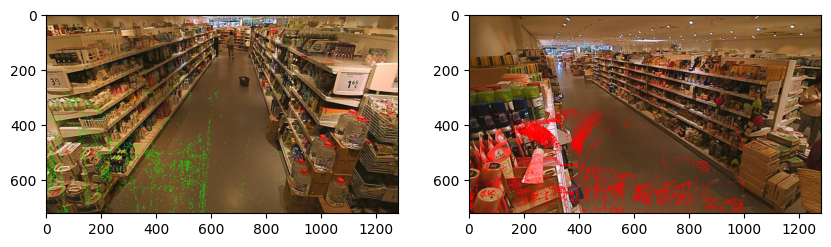

In [32]:
import cv2
import matplotlib.pyplot as plt
# visualise the features detected in the image
# create plot with 2 subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

img = cv2.imread('/Users/grosche/Documents/GitHub/CVLAB/MARMOT/data/0-calibration/opensfm/images/cam1_3239.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img2 = cv2.imread('/Users/grosche/Documents/GitHub/CVLAB/MARMOT/data/0-calibration/opensfm/images/cam2_3239.jpg')
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
for point in denormed_feats:
    point = tuple(map(int, point))
    cv2.circle(img, point, 1, (0, 255, 0), -1)

for point in denormed_feats_2:
    point = tuple(map(int, point))
    cv2.circle(img2, point, 1, (255, 0, 0), -1)
axs[0].imshow(img)
axs[1].imshow(img2)

plt.show()


In [2]:
matches

{'cam4_12030.jpg': array([], dtype=float64),
 'cam360_765.jpg': array([], dtype=float64),
 'cam360_587.jpg': array([], dtype=float64),
 'cam3_12160.jpg': array([], dtype=float64),
 'cam3_1351.jpg': array([], dtype=float64),
 'cam360_232.jpg': array([[ 2844, 11180],
        [ 4954, 16416],
        [ 5210, 18810],
        [ 4582, 13102],
        [ 4896, 15595],
        [ 5087, 17286],
        [ 1492,  9989],
        [ 3002, 13082],
        [ 5199, 18771],
        [ 2470,  6521],
        [ 5091, 18374],
        [ 5059, 18467],
        [ 4793, 16453],
        [ 2831,  5776],
        [ 5142, 18336],
        [ 4089, 14505],
        [ 4588, 15211],
        [  919,   249],
        [ 4334, 15361],
        [ 2688,  3834],
        [ 2375, 11971],
        [ 2329,  5279],
        [ 5104, 17504],
        [ 2361,  9459],
        [  759,  2243],
        [ 1651, 14289],
        [ 4155, 15961],
        [ 4407, 10882],
        [ 4895, 15596],
        [  764,  2929],
        [ 1391,  9107],
        [  632

In [38]:
import cv2
import tkinter as tk
from tkinter import ttk

# Load your initial images
img1 = cv2.imread('/Users/grosche/Documents/GitHub/CVLAB/MARMOT/data/opensfm/images/cam1_432.jpg')
img2 = cv2.imread('/Users/grosche/Documents/GitHub/CVLAB/MARMOT/data/opensfm/images/cam2_1291.jpg')

# Create a Tkinter window
window = tk.Tk()
window.title("Image Overlay Tool")

# Create a Canvas widget to display the images
canvas1 = tk.Canvas(window, width=img1.shape[1], height=img1.shape[0])
canvas1.pack(side=tk.LEFT)

canvas2 = tk.Canvas(window, width=img2.shape[1], height=img2.shape[0])
canvas2.pack(side=tk.RIGHT)

# Dropdown menu for selecting different images
image_options = ['img1.jpg', 'img2.jpg', 'img3.jpg']  # Add your image file names
selected_image = tk.StringVar()
selected_image.set(image_options[0])  # Set initial image

def change_image(*args):
    selected_filename = selected_image.get()
    if selected_filename == 'img1.jpg':
        display_image(img1, matches)
    elif selected_filename == 'img2.jpg':
        display_image(img2, matches)

image_dropdown = ttk.Combobox(window, textvariable=selected_image, values=image_options)
image_dropdown.pack()
image_dropdown.bind("<<ComboboxSelected>>", change_image)

# List of matches (match_id, (x1, y1), (x2, y2))
matches = [
    {"match_id": 1, "match_loc_img_1": (100, 100), "match_loc_img_2": (200, 200)},
    {"match_id": 2, "match_loc_img_1": (150, 150), "match_loc_img_2": (250, 250)},
    # Add more matches as needed
]

# Function to display the image with overlaid features and matches
def display_image(image, matches):
    if image is img1:
        canvas = canvas1
    else:
        canvas = canvas2

    canvas.delete("all")  # Clear the canvas
    # canvas.create_image(0, 0, anchor=tk.NW, image=tk.PhotoImage(data=""))
    canvas.create_image(0, 0, anchor=tk.NW, image=tk.PhotoImage(data=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)))

    # Overlay features on the image
    for point in denormed_feats:
        point = tuple(map(int, point))
        canvas.create_oval(point[0]-2, point[1]-2, point[0]+2, point[1]+2, fill="green", outline="green")

    # Highlight matches
    x_hovered, y_hovered = canvas.winfo_pointerx() - canvas.winfo_rootx(), canvas.winfo_pointery() - canvas.winfo_rooty()
    for match in matches:
        x1, y1 = match["match_loc_img_1"]
        x2, y2 = match["match_loc_img_2"]
        if abs(x1 - x_hovered) <= 2 and abs(y1 - y_hovered) <= 2:
            canvas.create_oval(x1-2, y1-2, x1+2, y1+2, fill="red", outline="red")
            canvas2.create_oval(x2-2, y2-2, x2+2, y2+2, fill="red", outline="red")
        else:
            canvas.create_oval(x1-2, y1-2, x1+2, y1+2, fill="green", outline="green")
            canvas2.create_oval(x2-2, y2-2, x2+2, y2+2, fill="green", outline="green")

# Function to handle hover events
def hover(event):
    selected_filename = selected_image.get()
    if selected_filename == 'img1.jpg':
        display_image(img1, matches)
    elif selected_filename == 'img2.jpg':
        display_image(img2, matches)

canvas1.bind("<Motion>", hover)
canvas2.bind("<Motion>", hover)

# Display the initial image with features and matches
display_image(img1, matches)

window.mainloop()


TclError: couldn't recognize image data

: 